In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# Enable interactive plot
%matplotlib notebook

## Add Path

In [3]:
import os
import sys

In [4]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [5]:
del module_path

## Organize imports

In [6]:
from typing import Dict, List, Optional, Tuple, Union

In [7]:
from collections import OrderedDict

In [8]:
from pathlib import Path

In [9]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [10]:
import random

In [11]:
import numpy as np

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torchvision
from torchvision.models import resnet18, resnet34, resnet50
from torchvision import transforms
from torchvision.datasets import FashionMNIST, CIFAR10, STL10
import time
from tqdm.autonotebook import tqdm
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [13]:
import kornia.augmentation as K

In [14]:
from kornia.augmentation.utils import _shape_validation
from kornia.geometry.bbox import bbox_to_mask, infer_bbox_shape
from kornia.constants import BorderType, Resample
from kornia.augmentation import random_generator as rg

In [15]:
import pytorch_lightning as pl

In [16]:
torch.manual_seed(1)

## Define funcrtions

Define functions for model approximation

#### Function space

In [17]:
def funct_space(xs: np.ndarray, func: callable) -> np.ndarray:
    return func(xs)
    

# Sample X space

Generate random sample from $X$ spaces

In [18]:
X = np.random.uniform(low=-1, high=1, size=(200,))
X.shape, X

((200,),
 array([ 2.99886738e-01, -1.70902894e-01,  8.11491970e-01,  4.67423250e-01,
         4.76729413e-01,  9.49730507e-01, -5.34435711e-01, -8.36928041e-01,
         7.99048972e-01, -9.25156165e-01,  5.53319131e-01, -7.84916709e-01,
        -7.37995495e-01, -3.31451552e-01,  8.14867327e-01, -2.94076118e-01,
        -2.65849518e-01, -6.15311926e-01, -3.19836488e-01, -2.84459538e-01,
         9.40808672e-02, -2.66357096e-01, -8.73968761e-01,  1.48867383e-01,
        -9.17882486e-01, -2.45808095e-01,  4.30709693e-01, -1.94262057e-01,
        -6.96700541e-01,  4.05930769e-01,  7.23985953e-01,  9.67804116e-01,
         1.71567720e-02,  7.89054294e-01, -6.91938067e-01, -7.61951205e-01,
         6.07639890e-01,  6.91084721e-01,  8.12290004e-01, -8.42818986e-01,
         2.80258714e-01,  7.42796591e-01,  4.51496791e-01, -6.64980933e-01,
         2.08884195e-01,  7.38245880e-01, -7.60366097e-01,  6.82554182e-01,
        -5.81575154e-01,  6.96201239e-01,  7.98216835e-02, -2.32259358e-01,
   

In [20]:
y = funct_space(X, lambda x: x**2)
y.shape, y

((200,),
 array([8.99320554e-02, 2.92077993e-02, 6.58519218e-01, 2.18484495e-01,
        2.27270933e-01, 9.01988035e-01, 2.85621529e-01, 7.00448547e-01,
        6.38479260e-01, 8.55913929e-01, 3.06162061e-01, 6.16094239e-01,
        5.44637350e-01, 1.09860131e-01, 6.64008760e-01, 8.64807629e-02,
        7.06759662e-02, 3.78608766e-01, 1.02295379e-01, 8.09172286e-02,
        8.85120957e-03, 7.09461026e-02, 7.63821396e-01, 2.21614977e-02,
        8.42508258e-01, 6.04216194e-02, 1.85510840e-01, 3.77377467e-02,
        4.85391644e-01, 1.64779790e-01, 5.24155660e-01, 9.36644807e-01,
        2.94354824e-04, 6.22606678e-01, 4.78778288e-01, 5.80569639e-01,
        3.69226235e-01, 4.77598091e-01, 6.59815051e-01, 7.10343843e-01,
        7.85449465e-02, 5.51746775e-01, 2.03849352e-01, 4.42199642e-01,
        4.36326068e-02, 5.45006979e-01, 5.78156601e-01, 4.65880211e-01,
        3.38229660e-01, 4.84696166e-01, 6.37150115e-03, 5.39444093e-02,
        1.21441838e-01, 2.20437271e-01, 5.56454142e-01,

In [21]:
# list(zip(X, y))

<IPython.core.display.Javascript object>


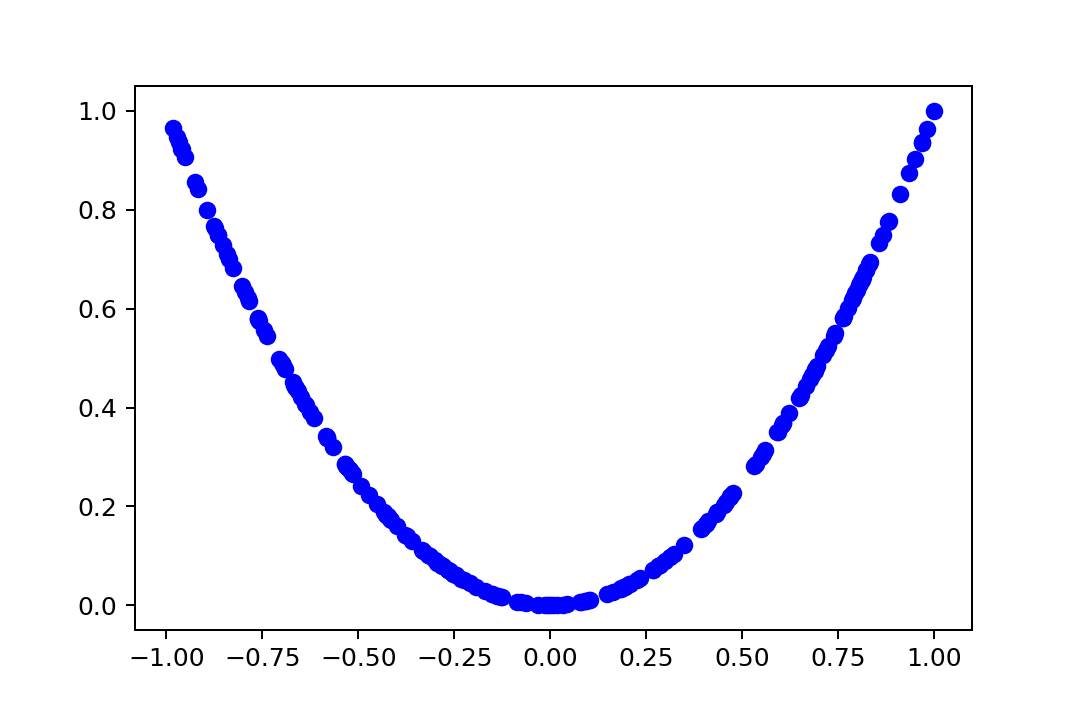

In [22]:
plt.plot(X, y, 'bo')
plt.show()
# plt.close()

## Define model

In [23]:
in_features = 1
out_features = 1
hidden_features = 10

In [24]:
class LinNN(nn.Module):
    
    def __init__(self, n_in: int = 1, n_midd: int=4, n_out: int = 1):
        super().__init__()
        self.fc1 = nn.Linear(n_in, n_midd, bias=True)
        self.fc2 = nn.Linear(n_midd, n_out, bias=True)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = self.fc1(x)
        z = self.fc2(h)
        
        return z

In [28]:
def init_net(
    in_features=in_features, hidden_features=hidden_features, 
    out_features=out_features):
    return nn.Sequential(OrderedDict([
            ('fn1', nn.Linear(in_features, hidden_features, bias=True)),
            ('a1', nn.ReLU()),
            ('fn2', nn.Linear(hidden_features, out_features, bias=True)),
        ]))

## Set-up the training

In [29]:
func_ds = TensorDataset(torch.Tensor(X),torch.Tensor(y)) # create your datset
func_dl = DataLoader(func_ds)

In [30]:
net = init_net()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
loss = torch.nn.MSELoss()

In [31]:
class LtModel(pl.LightningModule):
    def __init__(self, net: nn.Module, opt, loss):
        super().__init__()
        self.net = net
        self.opt = opt
        self.loss = loss
        self.imgs = list()
        fig, ax = self._init_plt()
        self.fig = fig
        self.ax = ax
        
    @staticmethod
    def _init_plt():
        plt.figure(figsize=(10,4))
        plt.scatter(X, y, color = "orange")
        plt.title('Regression Analysis')
        plt.xlabel('Independent varible')
        plt.ylabel('Dependent varible')
        plt.show()
        fig, ax = plt.subplots(figsize=(12,7))
        
        return fig, ax
    
    @staticmethod
    def plot_progress(ax, fig, x_t, y_t, y_hat, loss, t):
        # plot and show learning process
        x_v = x_t.to('cpu').data.numpy()
        y_v = y_t.to('cpu').data.numpy()
        y_hat_v = y_hat.to('cpu').data.numpy()
        ls_v = loss.to('cpu').data.numpy()
        plt.cla()
        ax.set_title('Regression Analysis', fontsize=35)
        ax.set_xlabel('Independent variable', fontsize=24)
        ax.set_ylabel('Dependent variable', fontsize=24)
        ax.set_xlim(-1.0, 1.0)
        ax.set_ylim(-1.0, 1.0)
        ax.scatter(x_v, y_v, color = "orange")
        #         ax.plot(x_v, y_hat_v, 'g-', lw=3)
        ax.scatter(x_v, y_hat_v, color = "blue")
        ax.text(1.0, 0.1, 'Step = %d' % t, fontdict={'size': 24, 'color':  'red'})
        ax.text(1.0, 0, 'Loss = %.4f' % ls_v,
                fontdict={'size': 24, 'color':  'red'})

        # Used to return the plot as an image array 
        # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
        fig.canvas.draw()       # draw the canvas, cache the renderer
        
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        
        return image

    def forward(self, x):
        return self.net(x)
    
    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        # Logging to TensorBoard by default
        self.log("train_loss", loss)
        img = self.plot_progress(self,ax, self.fig, x, y, y_hat, loss, batch_idx)
        self.imgs.append(img)
        
        return loss

    def configure_optimizers(self):
        return self.opt

## Perform custom training

In [32]:
X_t = torch.unsqueeze(torch.Tensor(X), dim=1)
y_t = torch.unsqueeze(torch.Tensor(y), dim=1)
X_t.shape, X_t.dtype

(torch.Size([200, 1]), torch.float32)

<IPython.core.display.Javascript object>


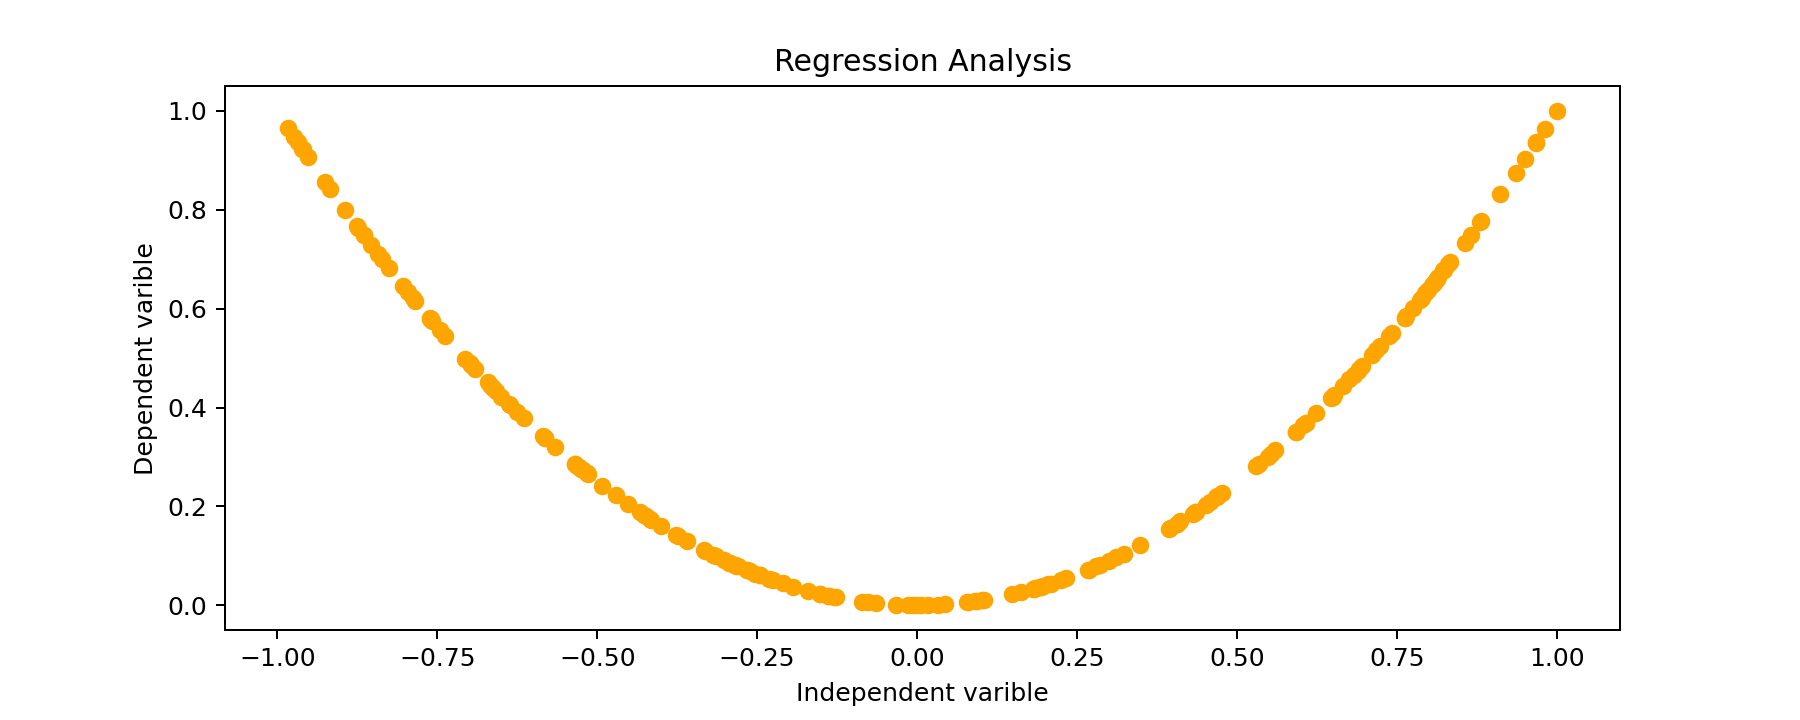

<IPython.core.display.Javascript object>


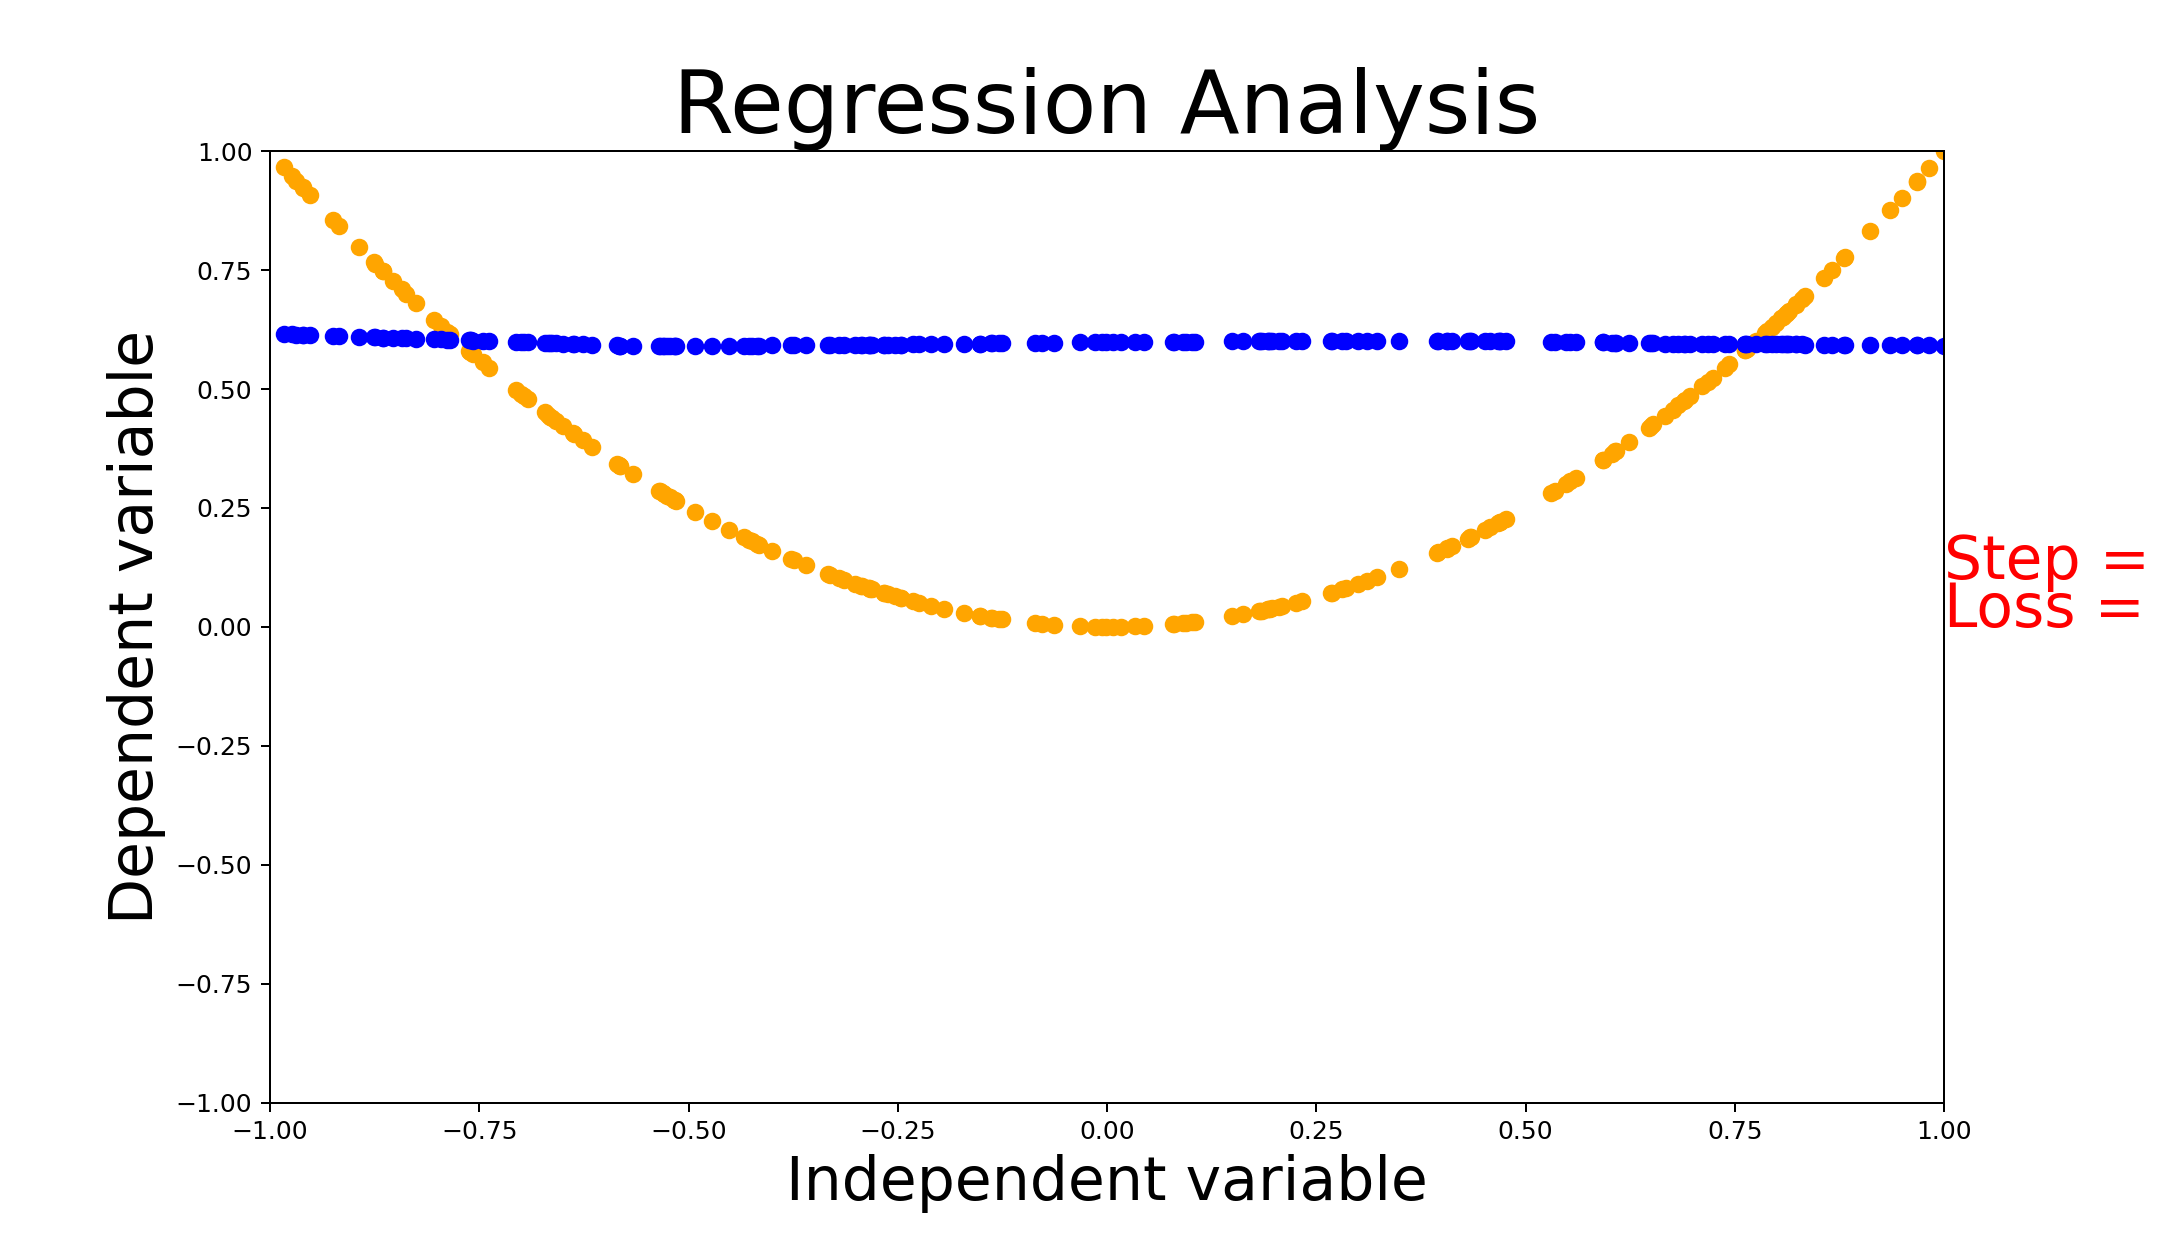

/Users/levan/anaconda3/envs/edu/lib/python3.9/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


KeyboardInterrupt: 

In [33]:
plt.close()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
loss = torch.nn.MSELoss()
fig, ax = LtModel._init_plt()
net = init_net()
epochs  = 500
net.train()
imgs = list()
for ep in range(epochs):
    y_hat = net(X_t)
    y_hat = F.sigmoid(y_hat)
    ls = loss(y_hat, y_t)
    optimizer.zero_grad()
    ls.backward()
    optimizer.step()
    img = LtModel.plot_progress(ax, fig, X_t, y_t, y_hat, ls, ep + 1)
    imgs.append(img)

<IPython.core.display.Javascript object>


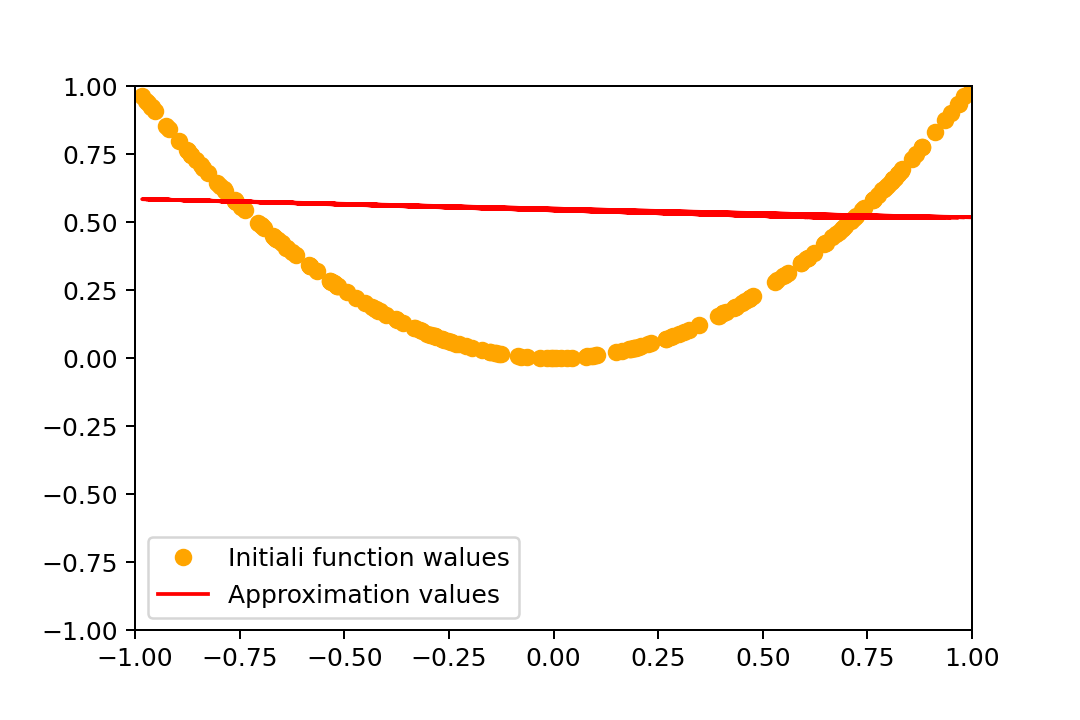

/var/folders/t0/pbj59l394sdcgxqh8gvj099h0000gn/T/ipykernel_25114/1127226892.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  scatter, = ax.plot(


<IPython.core.display.Javascript object>


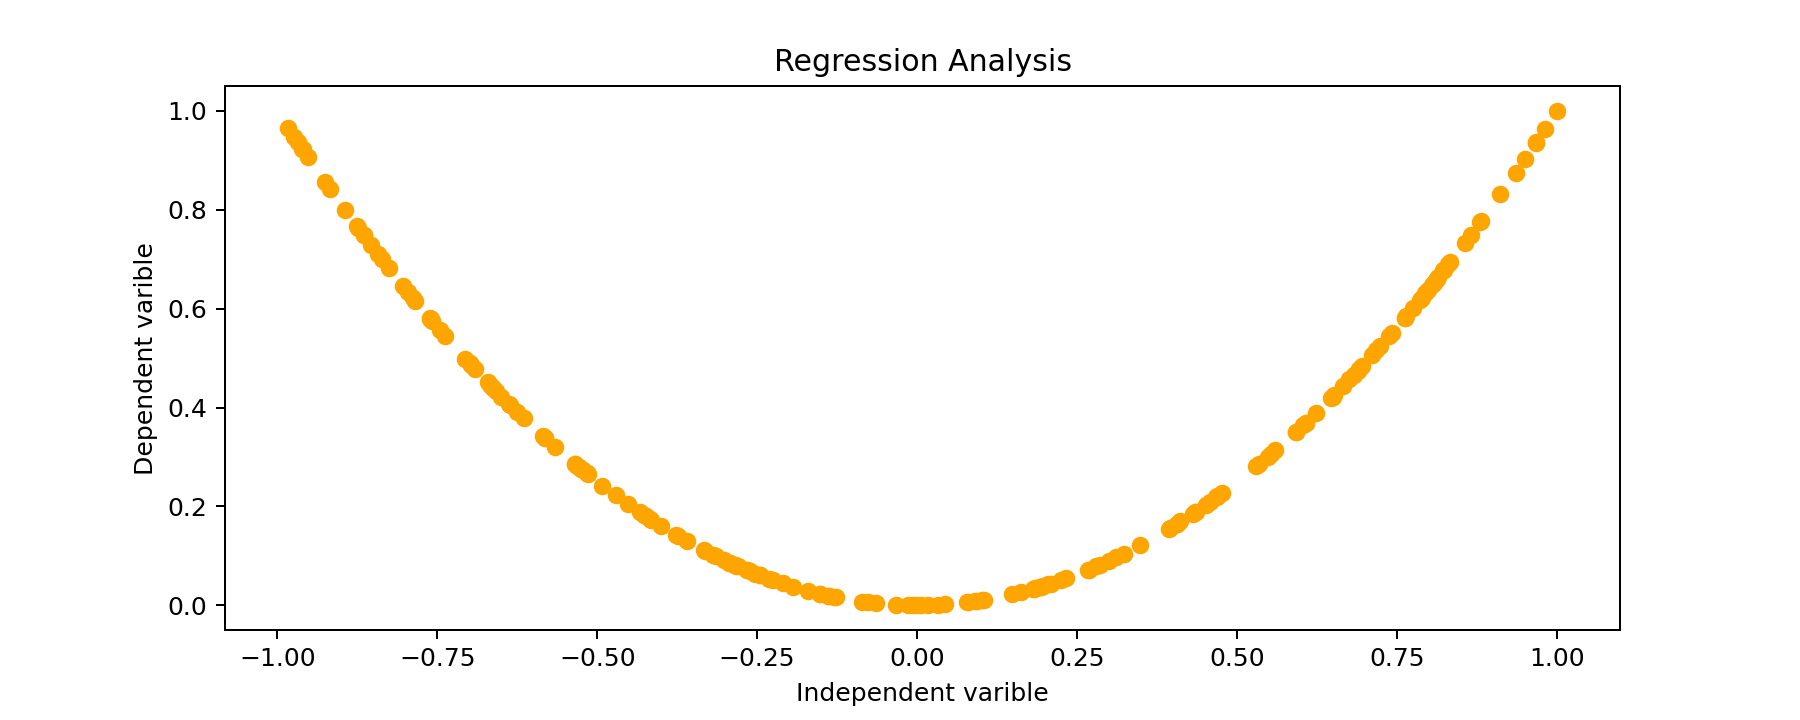

<IPython.core.display.Javascript object>


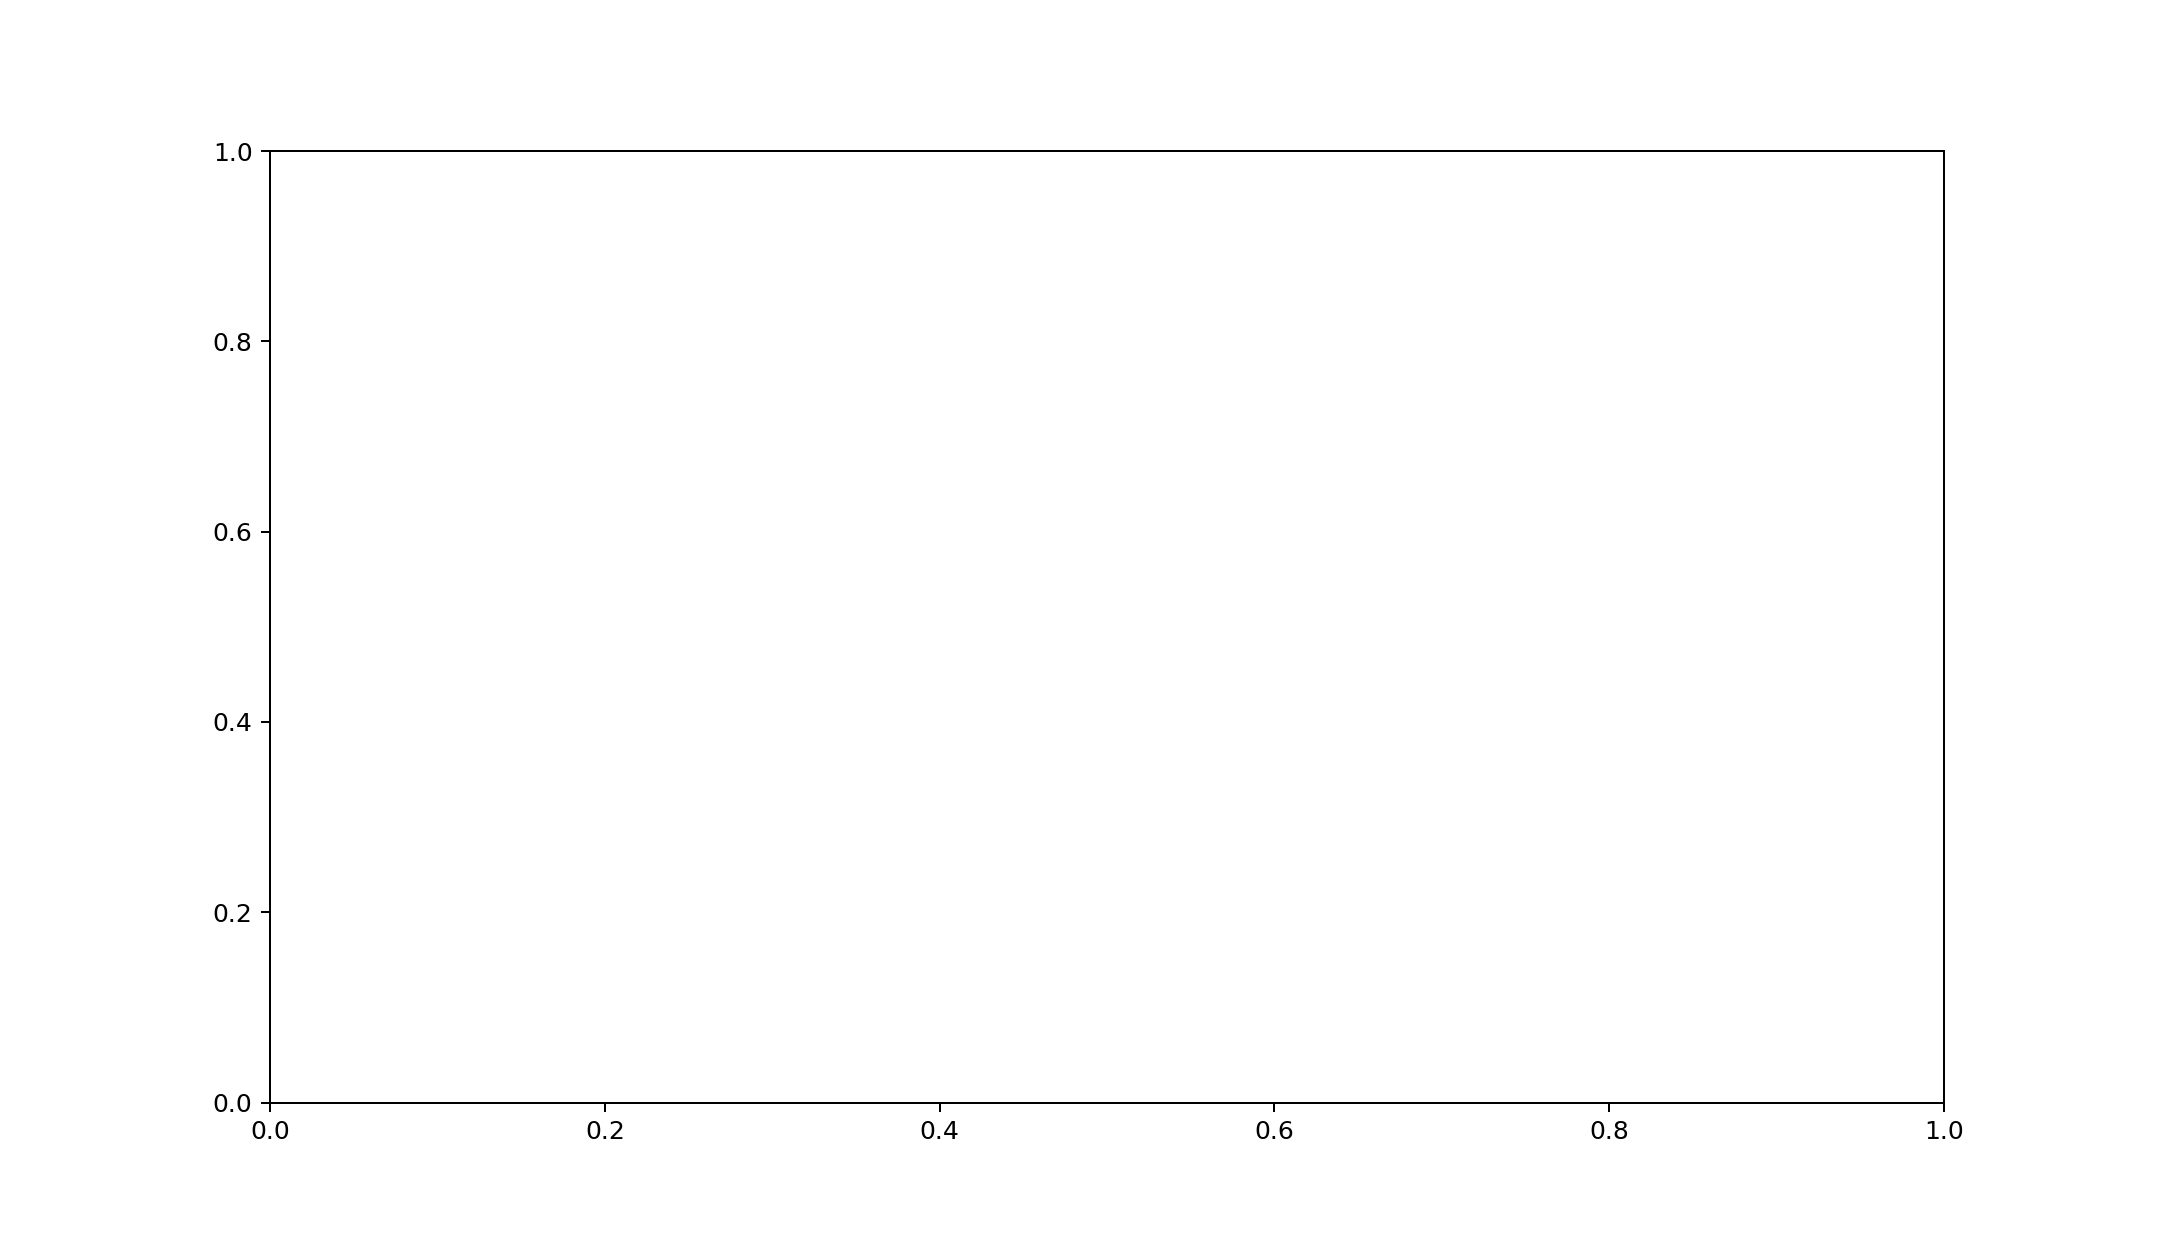

In [34]:
fig, ax = plt.subplots() 
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

scatter, = ax.plot(
    [], [], 'go', label='Initiali function walues', color='orange')
line, = ax.plot([], [], 'r', label='Approximation values')
ax.legend()

def anim(frame_number):
    y_hat = net(X_t)
    y_hat = F.sigmoid(y_hat)
    ls = loss(y_hat, y_t)
    optimizer.zero_grad()
    ls.backward()
    optimizer.step()
    
    y_hat_np = torch.squeeze(y_hat).to('cpu').data.numpy()
    scatter.set_data((X, y))
    line.set_data((X, y_hat_np))
    

optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
loss = torch.nn.MSELoss()
fig, ax = LtModel._init_plt()
net = init_net()
epochs  = 500
net.train()
anm = FuncAnimation(fig, anim, frames=500, interval=5)

In [38]:
import imageio

In [39]:
imageio.mimsave('./curve_1.gif', imgs, fps=10)

## Perform training

<IPython.core.display.Javascript object>


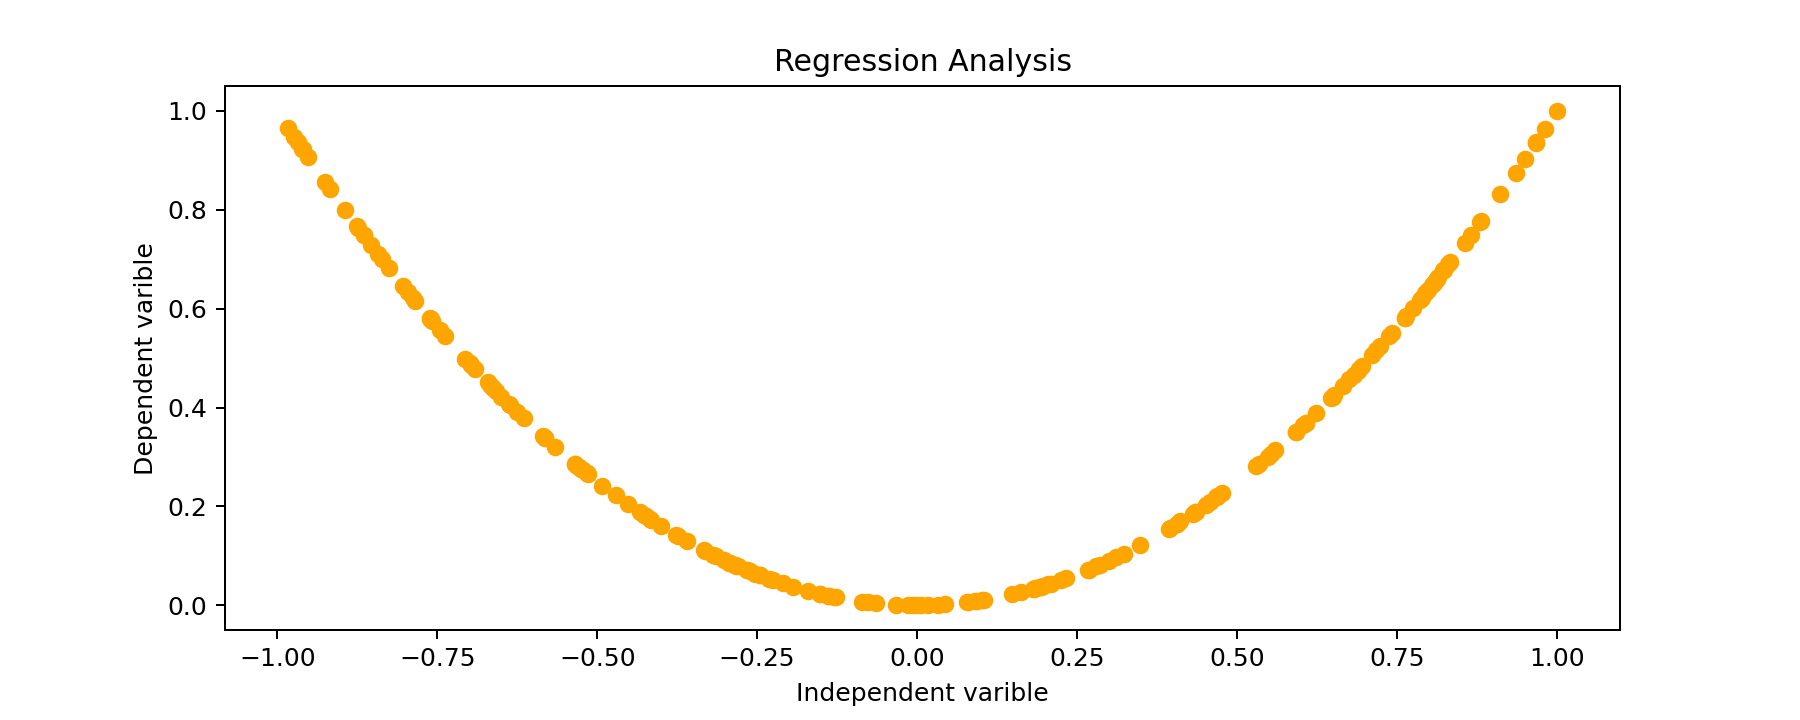

<IPython.core.display.Javascript object>


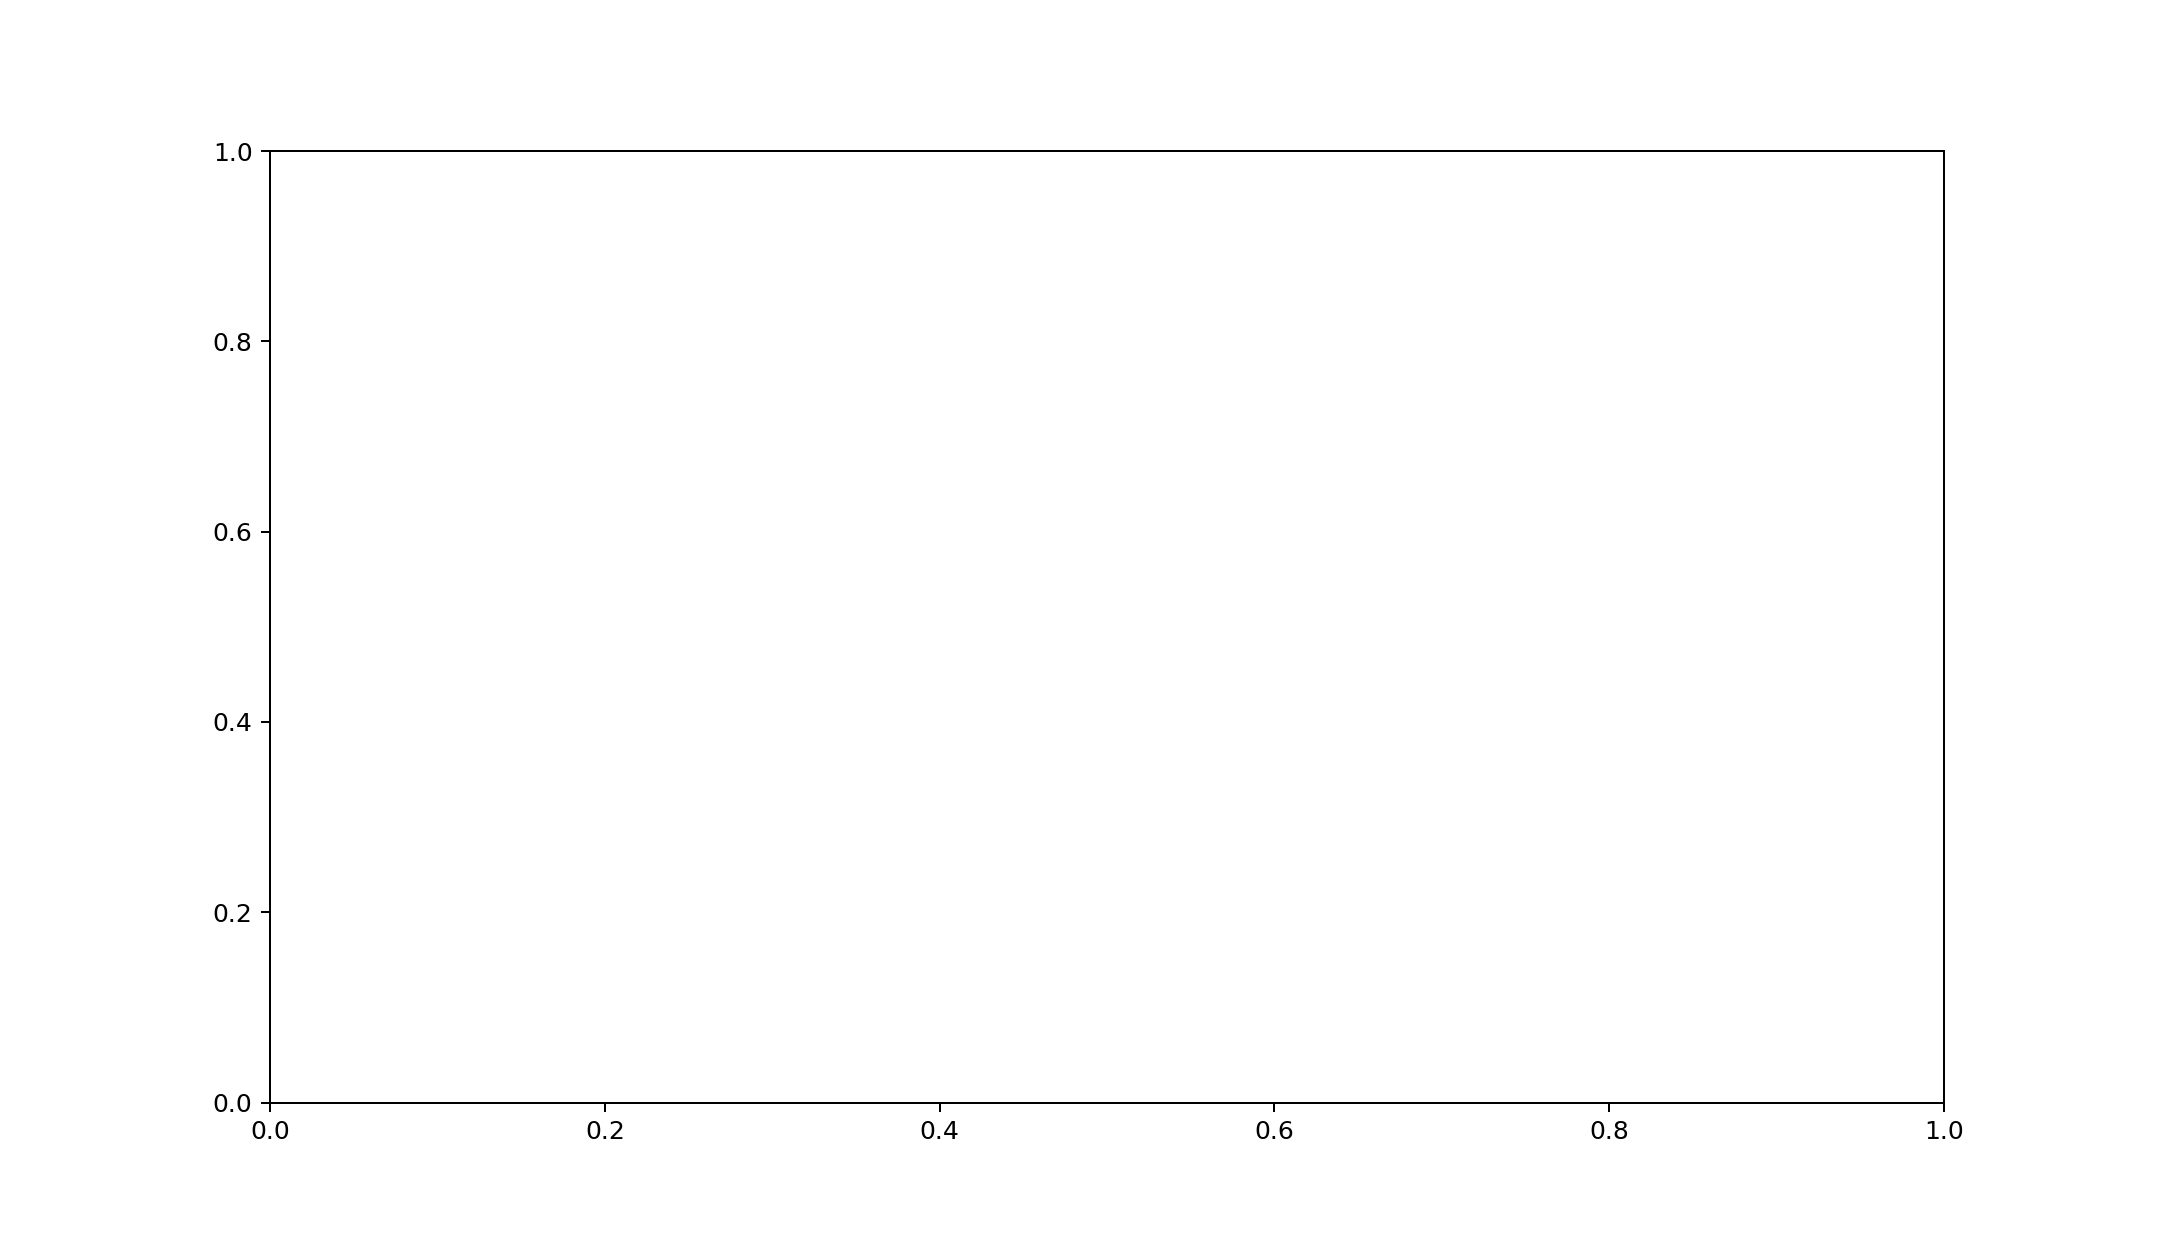

In [40]:
lt_model = LtModel(net, optimizer, loss)

In [41]:
trainer = pl.Trainer(max_epochs=10)
trainer.fit(lt_model, func_dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 31    
1 | loss | MSELoss    | 0     
------------------------------------
31        Trainable params
0         Non-trainable params
31        Total params
0.000     Total estimated model params size (MB)
/Users/levan/anaconda3/envs/edu/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

TypeError: plot_progress() takes 7 positional arguments but 8 were given